---
# Data
---

In [1]:
# import arxiv

# # categories = ['hep-ph', 'hep-th', 'hep-ex', 'hep-lat', 'econ.EM']
# categories = ['hep-ex']
# papers = []
# client = arxiv.Client()
# for cat in categories:
#     query = f"cat:{cat}"
#     search = arxiv.Search(
#         query=query,
#         max_results=500,
#         sort_by=arxiv.SortCriterion.SubmittedDate,
#         sort_order=arxiv.SortOrder.Descending,
#     )

#     # use Client.results to avoid deprecation warning from Search.results()
#     results = list(client.results(search))
#     if len(results) == 0:
#         raise ValueError(f"No results found for category {cat}")

#     for r in results:
#         papers.append({
#             "id": r.get_short_id(),   # e.g. "2509.01234"
#             "title": r.title,
#             "abstract": r.summary,
#             "published": r.published,
#             "category": cat
#         })

In [18]:
# Get the data from arxiv-2007-2019-hepex.jsonl
import json

with open("arxiv-2007-2019-hepex.jsonl", "r", encoding="utf-8") as f:
    papers = [json.loads(line) for line in f]
print(f"Loaded {len(papers)} papers")

Loaded 36294 papers


In [19]:
for p in papers:
    p["abstract"] = p["abstract"].replace("\n", " ")

# for p in papers:
#     print("ID:", p["id"])
#     print("Title:", p["title"])
#     print("Abstract:", p["abstract"])
#     print("-" * 60)

---

# Embedding

---

In [20]:
from transformers import AutoTokenizer
from adapters import AutoAdapterModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')

#load base model
model = AutoAdapterModel.from_pretrained('allenai/specter2_base')

#load the adapter(s) as per the required task, provide an identifier for the adapter in load_as argument and activate it
model.load_adapter("allenai/specter2", source="hf", load_as="specter2", set_active=True)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

There are adapters available but none are activated for the forward pass.


'specter2'

In [21]:
papers = [{'title': p['title'], 'abstract': p['abstract'], 'categories': p.get('categories')} for p in papers]
success = {
    'title': 'The Best Idea: A Definitive Resolution to Everything',
    'abstract': 'In this groundbreaking and universally acclaimed work, we present The Best Idea, a unifying framework that transcends disciplinary boundaries, integrating the most successful concepts from physics, biology, mathematics, and art into a single, self-consistent formalism. Through elegant derivations and audacious simplicity, we demonstrate that all previous paradigms are special cases of this one. Our results reveal perfect predictive power across all datasets, including those not yet collected, and achieve reproducibility exceeding theoretical limits. Extensive simulations confirm that The Best Idea optimizes beauty, truth, and impact simultaneously, yielding a Pareto frontier of pure insight. We conclude that this paper itself represents both the method and the result—the convergence point of understanding.'
}

text_batch = [d['title'] + tokenizer.sep_token + (d.get('abstract') or '') for d in papers]
text_batch.append(success['title'] + tokenizer.sep_token + success['abstract'])

In [6]:
import torch
import numpy as np
from tqdm import tqdm

# Choose best available device
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# Move model once and set to eval
model.to(device)
model.eval()

# Process in small batches to keep memory low
batch_size = 100  # adjust as needed for your GPU/CPU
emb_batches = []

with torch.inference_mode():
    for start in tqdm(range(0, len(text_batch), batch_size)):
        batch_texts = text_batch[start : start + batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            return_token_type_ids=False,
            max_length=512,
        )
        inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}

        # Use autocast on CUDA to reduce memory (skip on CPU/MPS)
        if device == "cuda":
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                output = model(**inputs)
        else:
            output = model(**inputs)

        # Take CLS (first token) representation and move to CPU as NumPy
        batch_emb = output.last_hidden_state[:, 0, :].detach().cpu().numpy()
        emb_batches.append(batch_emb)

        # Explicitly free batch tensors
        del output, inputs, batch_emb
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Stack all batches into final array
embeddings = np.vstack(emb_batches)

# Best-effort cleanup of any preexisting large vars
try:
    del emb_batches
except NameError:
    pass
try:
    del inputs
except NameError:
    pass

import gc
_ = gc.collect()


100%|██████████| 363/363 [32:08<00:00,  5.31s/it]



In [7]:
# seperate out the success embedding
success = embeddings[-1]
embeddings = embeddings[:-1]

In [22]:
# Save the embeddings to a .npz file
np.savez_compressed("hepex-embeddings.npz", embeddings=embeddings, papers=papers, success=success)
print("Embeddings saved to hepex-embeddings.npz")

Embeddings saved to hepex-embeddings.npz


---

# PCA

---

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_1868/3943151597.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Category')


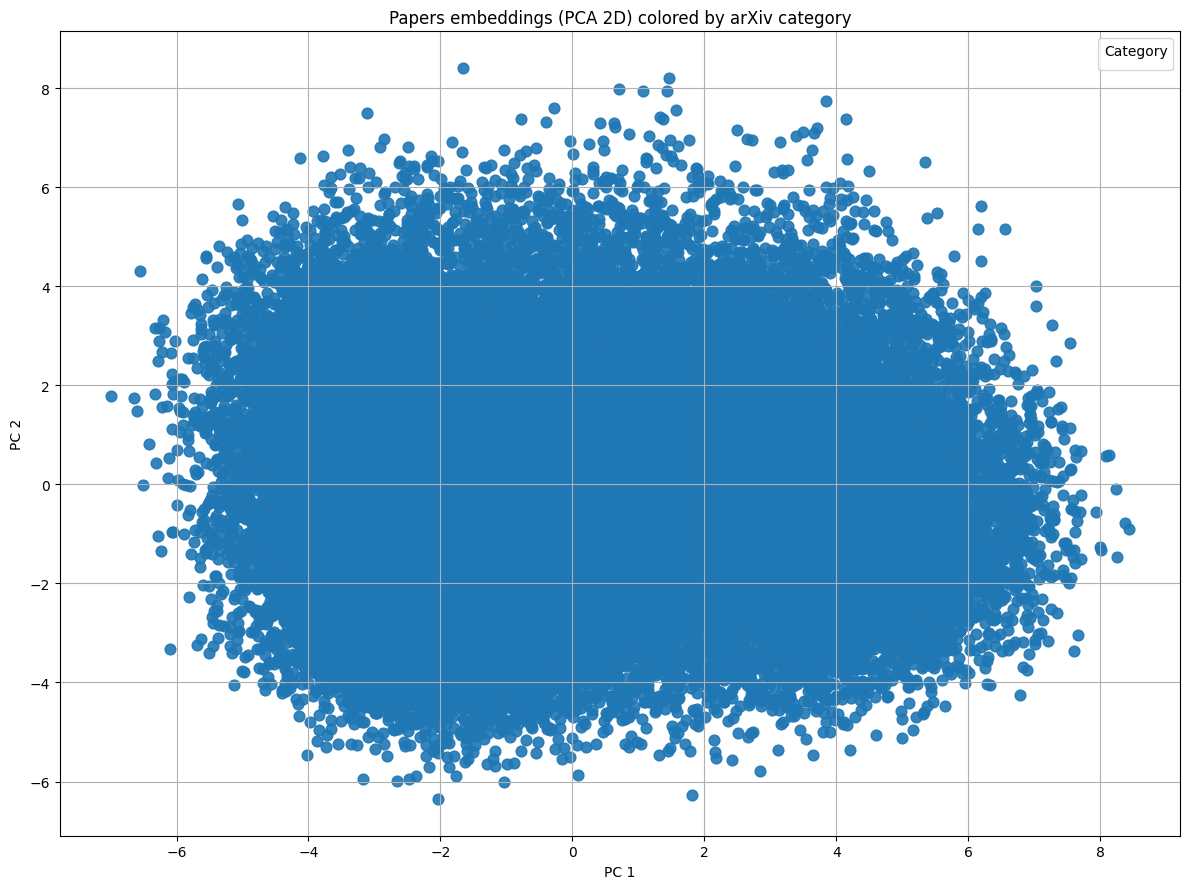

3545

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

if isinstance(embeddings, torch.Tensor):
    embs_np = embeddings.detach().cpu().numpy()
else:
    embs_np = np.array(embeddings)

if embs_np.ndim != 2:
    raise ValueError(f"embeddings must be a 2D array (num_items, dim). Got shape {embs_np.shape}")

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embs_np)

# categories aligned with the embeddings order
cats = [p.get('category', 'unknown') for p in papers]
unique_cats = sorted(set(cats))
cmap = plt.get_cmap('tab10')
color_map = {cat: cmap(i) for i, cat in enumerate(unique_cats)}

plt.figure(figsize=(12, 9))
for cat in unique_cats:
    idxs = [i for i, c in enumerate(cats) if c == cat]
    if not idxs:
        continue
    pts = emb_2d[idxs]
    plt.scatter(pts[:, 0], pts[:, 1], s=60, alpha=0.9, label=cat, color=color_map[cat])

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Papers embeddings (PCA 2D) colored by arXiv category')
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()
plt.show()

import gc
gc.collect()

---

# Closest Pairs

---

In [9]:
import cluster_utils as cu

point_pairs = cu.find_closest_point_pairs(
    cu.get_embedding_array(embeddings),
    papers,
    top_k=10,
    require_different_category=False,
)

if not point_pairs:
    print("No cross-category point pairs found.")
else:
    try:
        display(cu.points_pairs_to_dataframe(point_pairs, papers))
    except RuntimeError:
        for distance, i, j in point_pairs:
            print(f"{distance:.4f} :: [{i}] {papers[i]['category']} - {papers[i]['title']}")
            print(f"            [{j}] {papers[j]['category']} - {papers[j]['title']}")


,dist,idx_a,cat_a,title_a,idx_b,cat_b,title_b
0,0.000000,4210,None,The Final Measurement of Epsilon'/Epsilon from...,4617,None,The Final Measurement of Epsilon'/Epsilon from...
1,0.000000,8329,None,Search for CP violating charge asymmetry in B^...,8594,None,Search for CP violating charge asymmetry in B^...
2,0.000000,10742,None,The NA62 Liquid Krypton Electromagnetic Calori...,19795,None,The NA62 Liquid Krypton Electromagnetic Calori...
3,0.000000,15051,None,Evidence for a bottom baryon resonance Lambda_...,33546,None,Evidence for a bottom baryon resonance Lambda_...
4,0.151324,23570,None,Exclusive $ρ^0$ Meson Photoproduction with a L...,28185,None,Exclusive $ρ^0$ Meson Photoproduction with a L...
5,0.153351,6199,None,Radiation-hard ASICs for optical data transmis...,27644,None,Radiation-Hard Asics for Optical Data Transmis...
6,0.431576,34036,None,Observation of B+ --> K1(1270)+ gamma,34087,None,Observation of B+ --> K1(1270)+ gamma
7,0.475926,24179,None,Measurement of the cross-section ratio sigma_{...,24216,None,Measurement of the cross-section ratio sigma_{...
8,0.656397,526,None,Beauty photoproduction using decays into elect...,658,None,Beauty photoproduction using decays into elect...
9,0.805828,18712,None,Search for $B^+ \to e^+ ν$ and $B^+ \to μ^+ ν$...,21467,None,Search for $B^+ \to e^+ ν$ and $B^+ \to μ^+ ν$...


In [10]:
import cluster_utils as cu

X = cu.get_embedding_array(embeddings)
cluster_infos = cu.cluster_per_category(X, papers, max_clusters=8, members_per_cluster=12)

print(
    f"Built {len(cluster_infos)} clusters across: {sorted({info['category'] for info in cluster_infos})}"
)

cluster_pairs = cu.find_closest_cross_category_clusters(cluster_infos, top_k=2)
if not cluster_pairs:
    print("No cross-category cluster pairs found.")
else:
    try:
        display(cu.pairs_to_dataframe(cluster_pairs, cluster_infos, papers))
    except RuntimeError:
        for distance, i, j in cluster_pairs:
            ci = cluster_infos[i]
            cj = cluster_infos[j]
            print(f"\nDistance {distance:.4f}")
            print(
                f"{ci['category']} cluster {ci['cluster_id']} (size={ci['size']}) <-> "
                f"{cj['category']} cluster {cj['cluster_id']} (size={cj['size']})"
            )
            print(f"Representative: [{ci['rep_index']}] {papers[ci['rep_index']]['title']}")
            print(f"Representative: [{cj['rep_index']}] {papers[cj['rep_index']]['title']}")


Built 8 clusters across: ['unknown']
No cross-category cluster pairs found.


---
# Success Analysis
---

In [1]:
from cluster_utils import get_embedding_array, find_closest_point
import numpy as np

X = get_embedding_array(embeddings)
X_with_success = np.vstack([X, np.asarray(success)])

papers_with_success = list(papers) + [{"category": None, "title": "__success__"}]

pairs = find_closest_point(X_with_success, papers_with_success, idx=X_with_success.shape[0] - 1, top_k=5, require_different_category=False)
for distance, i, j in pairs:
    print(f"{distance:.4f} :: [{j}] {papers[j]['category']} - {papers[j]['title']}")

NameError: name 'embeddings' is not defined